<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first set of problems deal with the Cora dataset[6], which is citation graph of scientific
papers. The nodes (papers) have features given by sparse bag-of-words vector that cor-
respond to 1433 keywords. There are seven categories of papers based on a classification
of the keywords. Out of the 2708 nodes 140 are labeled in the standard training set,
20 in each class. The dataset can be found: https://github.com/kimiyoung/planetoid or
through PyG.
You are welcome to use the Colab Notebook on node classification on the Cora dataset
provided in the PyTorch Geometric documentation. Either modify and run directly in
Google Colab or reuse relevant parts of the code in your own Jupyter notebook or other
environment.


1.   From the Planetoid Cora dataset, extract the number of nodes that are in the training set, validation set, and test set. Discuss briefly the implications for super-
vised versus semi-supervised learning.
2.   Train both a standard dense network using supervised learning and a network
using the convolution from equation 1 using semi-supervised learning.
3. Use t-SNE to visualize the results.
All of this is essentially provided in the Colab notebook referred to above. You are also
welcome to try out varying the depth and width of the network to improve the accuracy.









In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Aquire the dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

data = dataset[0].to(device)

Processing...
Done!


In [5]:
# Nodes for training, validation, and test sets
train_mask = data.train_mask.sum().item()
val_mask = data.val_mask.sum().item()
test_mask = data.test_mask.sum().item()

print(f'Training set nodes: {train_mask}')
print(f'Validation set nodes: {val_mask}')
print(f'Test set nodes: {test_mask}')

Training set nodes: 140
Validation set nodes: 500
Test set nodes: 1000


# Discussion (supervised vs semisupervised learning)

With only 140 labeled nodes in the training set, we need to use the unlabeled data in a clever way to improve how much the model can learn. This is common in reality as it is difficult or costly to label data. From what I understand it uses the distribution of the data to infer the labels of the unlabeled datapoints by how similar they are to the labeled datapoints.

In [12]:
# Dense NN
# Dense Neural Network
class DenseNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DenseNN, self).__init__()
        self.Linear1 = nn.Linear(input_dim, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.Linear3 = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, data):
        x = data.x
        x = self.ReLU(self.Linear1(x))
        x = self.ReLU(self.Linear2(x))
        x = self.Linear3(x)
        return F.softmax(x, dim=1)

# Graph Convolutional Network
class ConvNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, data):
        x, edgeIndex = data.x, data.edge_index
        x = self.ReLU(self.conv1(x, edgeIndex))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edgeIndex)
        return F.softmax(x, dim=1)

input_dim = dataset.num_node_features
hidden_dim = input_dim
output_dim = dataset.num_classes

dense_model = DenseNN(input_dim, hidden_dim, output_dim).to(device)
gcn_model = ConvNet(input_dim, hidden_dim, output_dim).to(device)

In [13]:
optimizer_dense = optim.Adam(dense_model.parameters(), lr=0.01)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

Epoch 1: Trainloss: -0.14300835132598877, ValidationLoss: -0.2290351241827011
Epoch 2: Trainloss: -0.43785813450813293, ValidationLoss: -0.33680692315101624
Epoch 3: Trainloss: -0.6981240510940552, ValidationLoss: -0.1941712200641632
Epoch 4: Trainloss: -0.6549280881881714, ValidationLoss: -0.32898667454719543
Epoch 5: Trainloss: -0.7714625000953674, ValidationLoss: -0.33842211961746216
Epoch 6: Trainloss: -0.7207598686218262, ValidationLoss: -0.3469579517841339
Epoch 7: Trainloss: -0.8249224424362183, ValidationLoss: -0.3510730564594269
Epoch 8: Trainloss: -0.8357117176055908, ValidationLoss: -0.3543548583984375
Epoch 9: Trainloss: -0.8428611755371094, ValidationLoss: -0.3585415184497833
Epoch 10: Trainloss: -0.8557853102684021, ValidationLoss: -0.367096483707428
Epoch 11: Trainloss: -0.8571428656578064, ValidationLoss: -0.3778250813484192
Epoch 12: Trainloss: -0.8571428656578064, ValidationLoss: -0.3811752498149872
Epoch 13: Trainloss: -0.8571428656578064, ValidationLoss: -0.38547289

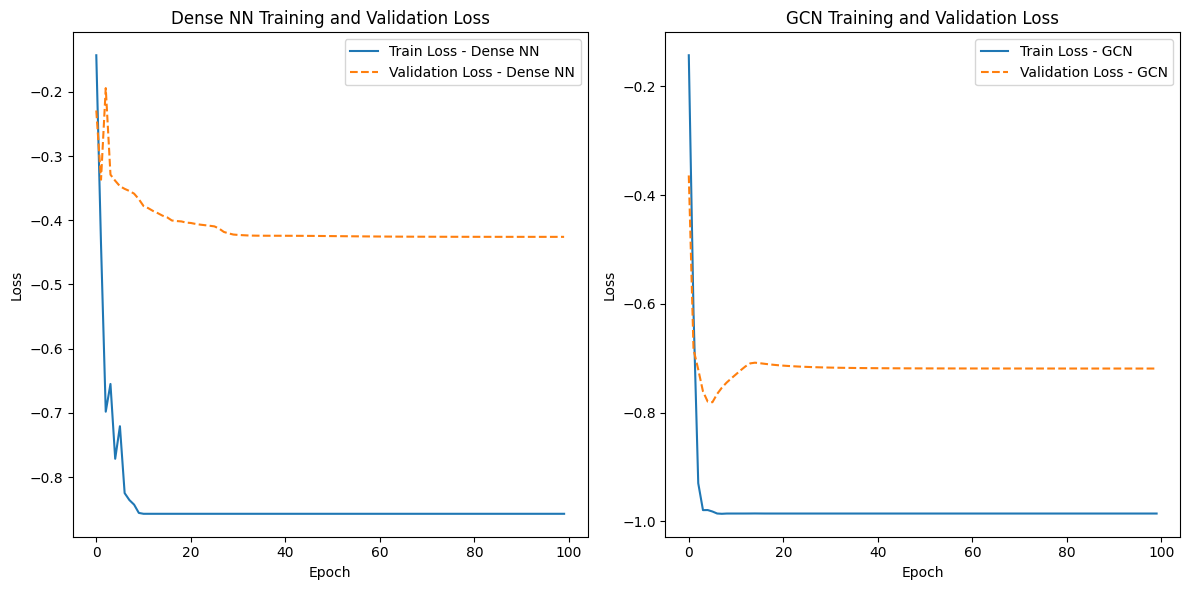

In [14]:
def train_and_validate(model, optimizer, criterion, data, train_mask, val_mask, num_epochs=100, model_name='model'):
    model.to(device)
    data.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[val_mask], data.y[val_mask])
            val_losses.append(val_loss.item())

            # Check for improvement and save the model if better
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'{model_name}_best.pth')
                #print(f'Epoch {epoch+1}: New best validation loss: {best_val_loss}')
            print(f'Epoch {epoch+1}: Trainloss: {train_losses[-1]}, ValidationLoss: {val_losses[-1]}')

    return train_losses, val_losses

# Training and validation
num_epochs = 100
train_losses_dense, val_losses_dense = train_and_validate(dense_model, optimizer_dense, criterion, data, data.train_mask, data.val_mask, num_epochs, 'dense_nn')
train_losses_gcn, val_losses_gcn = train_and_validate(gcn_model, optimizer_gcn, criterion, data, data.train_mask, data.val_mask, num_epochs, 'gcn_model')

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_dense, label='Train Loss - Dense NN')
plt.plot(val_losses_dense, label='Validation Loss - Dense NN', linestyle='--')
plt.title('Dense NN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_gcn, label='Train Loss - GCN')
plt.plot(val_losses_gcn, label='Validation Loss - GCN', linestyle='--')
plt.title('GCN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
dense_model.load_state_dict(torch.load("dense_nn_best.pth"))
gcn_model.load_state_dict(torch.load("gcn_model_best.pth"))

<All keys matched successfully>

In [16]:
def TSNE_visualize(model, data):
  model.eval()
  with torch.no_grad():
      out = model(data)  # Get the model outputs

  # Use t-SNE to reduce dimensionality
  tsne = TSNE(n_components=2, random_state=42)
  reduced = tsne.fit_transform(out.cpu().detach().numpy())  # Make sure the data is on CPU

  # Plot t-SNE
  plt.figure(figsize=(8, 8))
  scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=data.y.cpu().numpy(), cmap='viridis', alpha=0.6)
  plt.colorbar(scatter)
  plt.title('t-SNE Visualization of Node Embeddings')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.show()

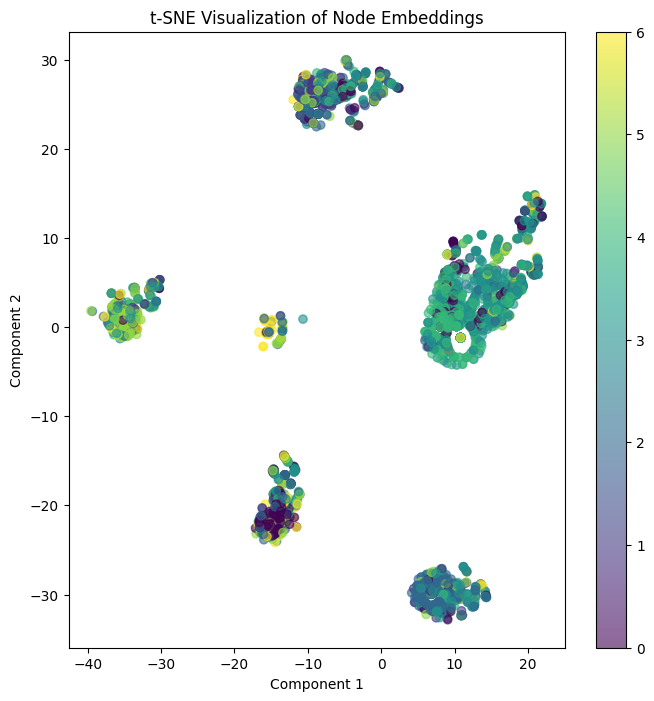

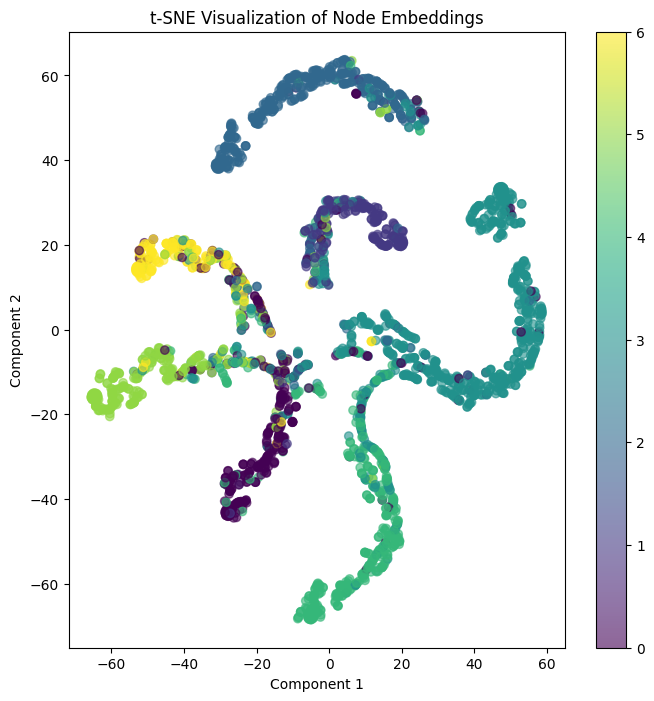

In [17]:
TSNE_visualize(dense_model, data)
TSNE_visualize(gcn_model, data)